### Defining best performance metrics to be used for this type of problem

For the most part I see RMSE for this type of problem utilized in other research. I will be using the same metric to evaluate my models.

### Build an automated process for testing various modelling techniques

In [1]:
# import statements to make code work
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

np.set_printoptions(precision=3, suppress=True)

2.9.1


In [2]:
# importing the data I will be using
path = 'data/AAPL_1980-12-12_2022-08-17.csv'

data = pd.read_csv(path)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


In [4]:
print(len(data))

10509


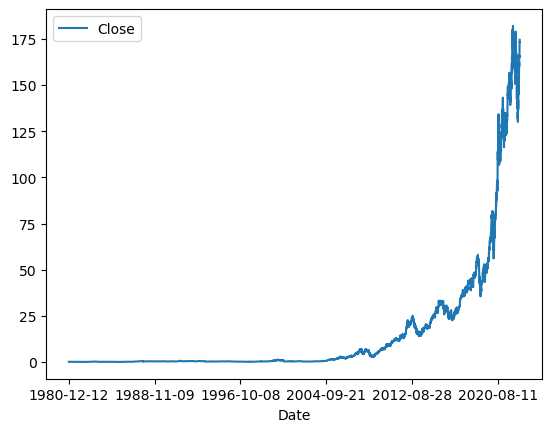

In [5]:
data.plot(x='Date', y='Close')

In [6]:
# Check for nulls
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler(feature_range=(0,1))

In [8]:
split_percent = .8
split_idx = int(split_percent * len(data))

close_prices = data[['Close']]
values = normalizer.fit_transform(close_prices.values)


train_data = values[:split_idx]
X_train = []
y_train = []

lbr = 63 # days in a financial quarter
for i in range(lbr, len(train_data)):
    X_train.append(train_data[i-lbr:i,0])
    y_train.append(train_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # transform to 3 dims

In [9]:
# now for test set
test_data = values[split_idx - lbr:]

X_test = []
y_test = values[split_idx:]

for i in range(lbr, len(test_data)):
    X_test.append(test_data[i-lbr:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
# setting up the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 63, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [27]:
# training the model
model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=.2)

Epoch 1/10
668/668 [==============================] - 8s 9ms/step - loss: 5.4758e-04 - val_loss: 0.0016
Epoch 2/10
668/668 [==============================] - 6s 9ms/step - loss: 3.6715e-04 - val_loss: 0.0033
Epoch 3/10
668/668 [==============================] - 6s 9ms/step - loss: 3.4962e-04 - val_loss: 0.0054
Epoch 4/10
668/668 [==============================] - 6s 9ms/step - loss: 3.2587e-04 - val_loss: 0.0086
Epoch 5/10
668/668 [==============================] - 6s 9ms/step - loss: 2.9875e-04 - val_loss: 0.0056
Epoch 6/10
668/668 [==============================] - 6s 9ms/step - loss: 3.0520e-04 - val_loss: 0.0102
Epoch 7/10
668/668 [==============================] - 6s 9ms/step - loss: 2.5794e-04 - val_loss: 0.0076
Epoch 8/10
668/668 [==============================] - 6s 9ms/step - loss: 2.7262e-04 - val_loss: 0.0079
Epoch 9/10
668/668 [==============================] - 6s 9ms/step - loss: 3.1816e-04 - val_loss: 0.0049
Epoch 10/10
668/668 [==============================] - 6s 9ms/st

In [28]:
predictions = model.predict(X_test)
predictions = normalizer.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

66/66 [==============================] - 1s 4ms/step


66.75261536138551

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


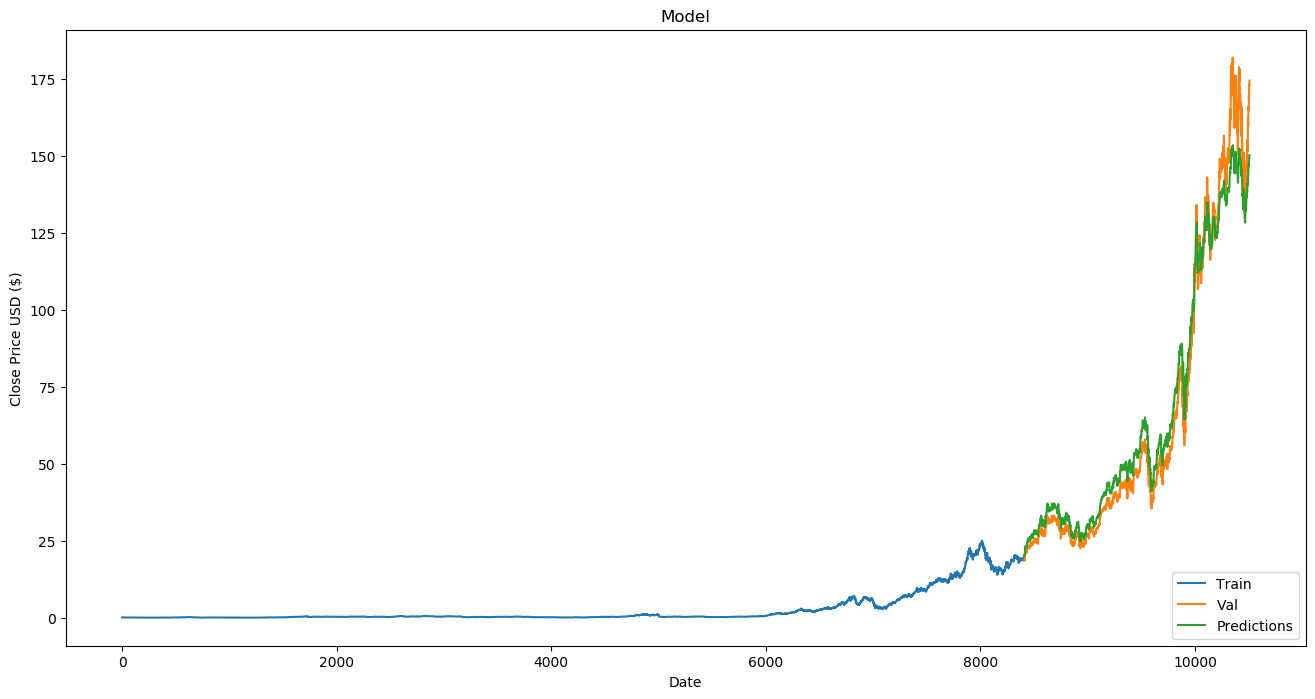

In [29]:
my_data = data.filter(['Close'])
train = my_data[:split_idx]
validation = my_data[split_idx:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
# creating an automated visualization tool
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

from sklearn.model_selection import GridSearchCV
# creating automated testing for hyper paramaters
def get_best_model(model, params, X_train, y_train):
    clf = GridSearchCV(estimator=model, param_grid=params)
    clf.fit(X_train, y_train)
    print("BEST PARAMS", clf.best_params_)
    best = clf.best_estimator_
    return best

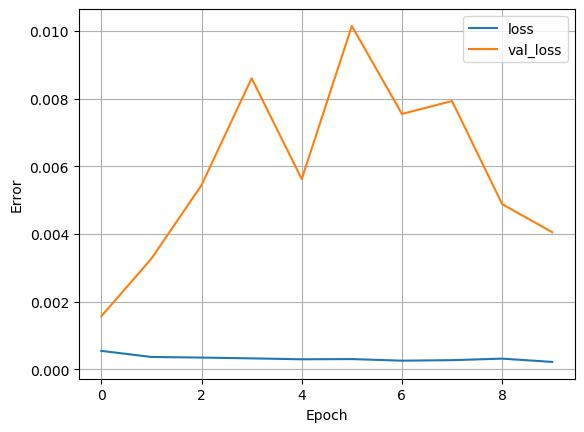

In [33]:
plot_loss(history)

In [ ]:

get_best_model()